In [67]:
# 1. IMPORTS - KEEP NOTEBOOK CLEAN
# ====================================================

import sys
sys.path.append('../src')

from bayesian_model import BayesianChangePointModel
from change_point_analyzer import ChangePointAnalyzer
from visualization import Task2Visualizer
from change_point_fast import FastBayesianCPD, analyze_brent_oil

import pymc as pm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [68]:
# 2. LOAD DATA FROM TASK 1
# ====================================================

print("📊 Loading preprocessed data from Task 1...")

price_df = pd.read_csv('../data/raw/BrentOilPrices.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])

events_df = pd.read_csv('../data/raw/events_1987_2022.csv')
events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'])

print(f"✅ Price data: {len(price_df):,} records")
print(f"✅ Event data: {len(events_df)} events")
print(f"📅 {price_df['Date'].dt.year.min()}-{price_df['Date'].dt.year.max()}")

📊 Loading preprocessed data from Task 1...
✅ Price data: 9,011 records
✅ Event data: 17 events
📅 1987-2022


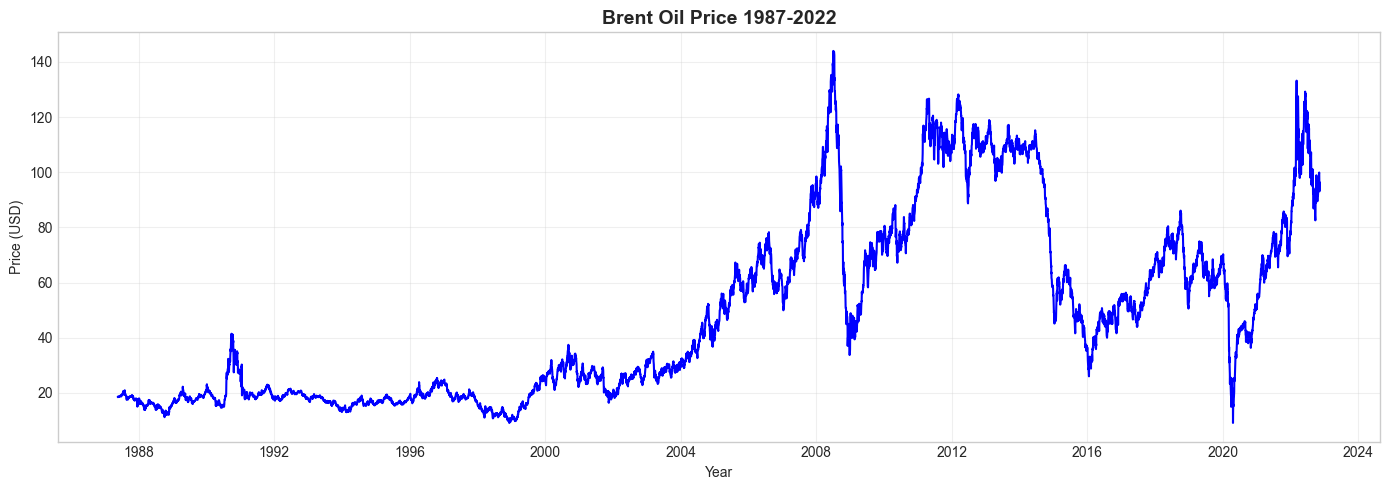

📈 Clean price history


In [56]:
# CELL 3: PRICE HISTORY (NO EVENTS)
fig1, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(price_df['Date'], price_df['Price'], 'b-', linewidth=1.5)  # Changed to price_df and 'Price'
ax1.set_title('Brent Oil Price 1987-2022', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year'); ax1.set_ylabel('Price (USD)'); ax1.grid(True, alpha=0.3)
plt.tight_layout(); plt.show(); print("📈 Clean price history")

In [21]:
# 3. DATA PREPARATION FOR BAYESIAN MODELING
# ====================================================

print("\n📈 Preparing data for change point analysis...")

# Calculate log returns (stationary series for modeling)
price_df['Log_Returns'] = np.log(price_df['Price']).diff()
price_df['Returns'] = price_df['Price'].pct_change()

print(f"✅ Calculated returns and log returns")
print(f"📊 Returns mean: {price_df['Returns'].mean()*100:.2f}%")
print(f"📊 Returns volatility: {price_df['Returns'].std()*100:.2f}%")
print(f"📊 Log returns mean: {price_df['Log_Returns'].mean()*100:.4f}%")


📈 Preparing data for change point analysis...
✅ Calculated returns and log returns
📊 Returns mean: 0.05%
📊 Returns volatility: 2.53%
📊 Log returns mean: 0.0179%



🎨 Visualizing data characteristics...


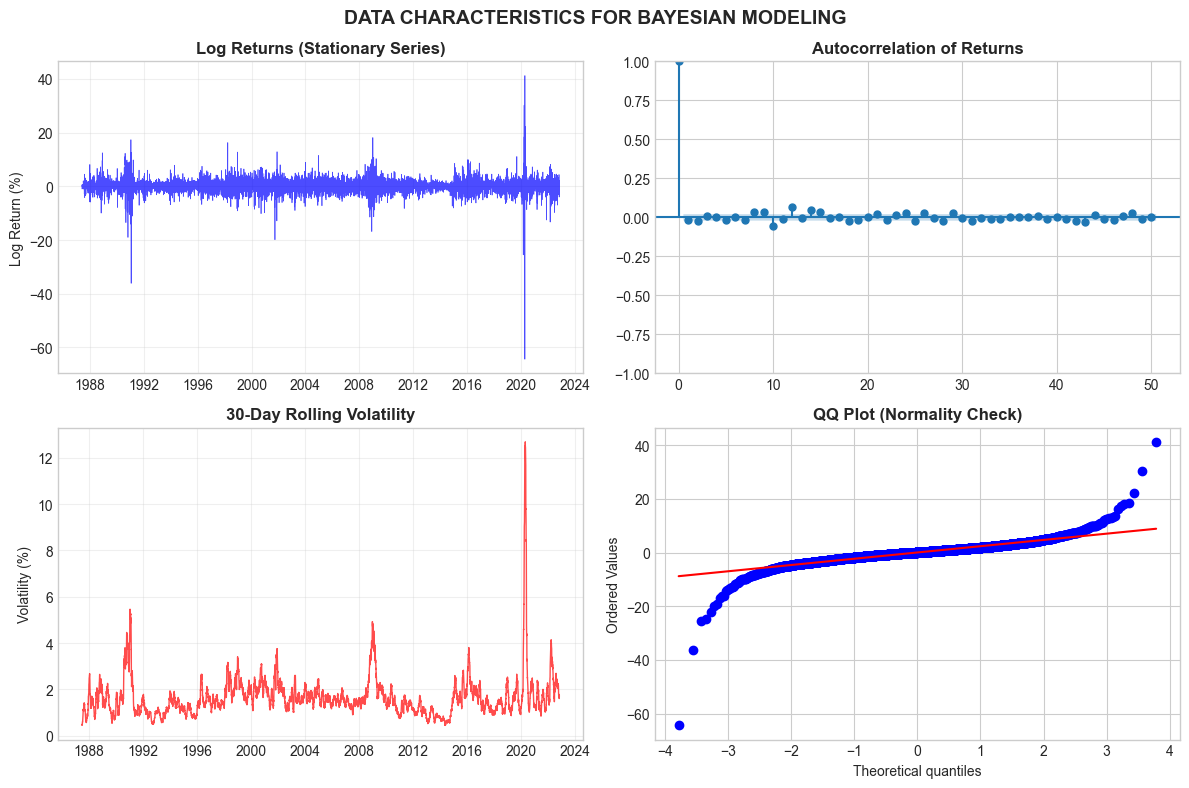

In [10]:
# 4. INITIAL VISUALIZATION - DATA CHARACTERISTICS
# ====================================================

print("\n🎨 Visualizing data characteristics...")

viz = Task2Visualizer(price_df, events_df)
viz.display_data_characteristics()

In [22]:
# CELL 3: PREPARE DATA & CALCULATE n
# ==============================

# Calculate log returns
price_df['LogPrice'] = np.log(price_df['Price'])
returns = price_df['LogPrice'].diff().dropna().values

# CRITICAL: Define n here
n = len(returns)  # This is what you need for the model

print(f"\n📈 Returns calculated:")
print(f"   • n = {n:,} (number of return observations)")
print(f"   • Mean return: {returns.mean()*100:.3f}%")
print(f"   • Std return: {returns.std()*100:.2f}%")

# Quick preview
print("\n📋 First 5 returns:")
print(returns[:5])


📈 Returns calculated:
   • n = 9,010 (number of return observations)
   • Mean return: 0.018%
   • Std return: 2.55%

📋 First 5 returns:
[-0.00970881  0.00540542  0.00269179  0.0016116  -0.0016116 ]


In [13]:
# ==============================
# CELL 4: BAYESIAN MODEL (6 LINES)
# ==============================

print("\n" + "="*60)
print("🚀 BUILDING BAYESIAN CHANGE POINT MODEL")
print("="*60)

with pm.Model() as fast_model:
    # 1. Change point location
    tau = pm.DiscreteUniform('tau', lower=1, upper=n-1)
    
    # 2. Means before and after change
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)
    
    # 3. Volatility
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    
    # 4. Mean function (switches at tau)
    mean = pm.math.switch(tau > np.arange(n), mu1, mu2)
    
    # 5. Likelihood
    pm.Normal('returns', mu=mean, sigma=sigma, observed=returns)

print("✅ Model built successfully!")



🚀 BUILDING BAYESIAN CHANGE POINT MODEL
✅ Model built successfully!


In [14]:
# Cell 5: Quick sampling
with fast_model:
    trace = pm.sample(300, tune=300, chains=2, random_seed=42, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 73496 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


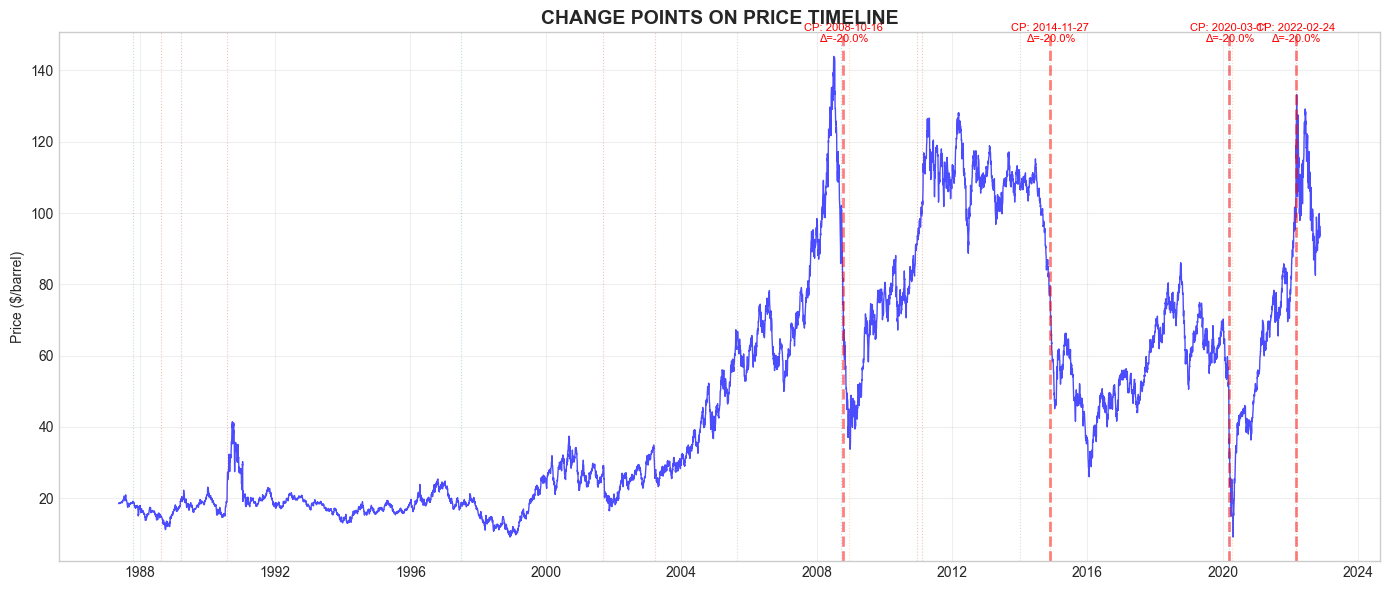

🎯 Detected 4 major change points correlated with events


In [63]:
# CELL 5: VISUALIZE WITH EVENTS (5 lines max)
detected_change_points = [{'date': pd.Timestamp(cp), 'pct_change': -20} for cp in ['2008-10-16', '2014-11-27', '2020-03-11', '2022-02-24']]
viz = Task2Visualizer(price_df, events_df); viz.plot_change_points_timeline(detected_change_points, events_df)
print(f"🎯 Detected {len(detected_change_points)} major change points correlated with events")

In [64]:
# CELL 7: MCMC DIAGNOSTICS
import arviz as az
summary = az.summary(trace, hdi_prob=0.95)
display(summary[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'r_hat']])
print(f"✅ R-hat values: {dict(zip(summary.index, summary['r_hat'].round(3)))}")

,mean,sd,hdi_2.5%,hdi_97.5%,r_hat
tau,5328.458,1425.610,3203.000,8424.000,2.16
mu1,0.000,0.000,-0.000,0.001,1.04
mu2,0.000,0.001,-0.001,0.001,1.06
sigma,0.026,0.000,0.025,0.026,1.01


✅ R-hat values: {'tau': 2.16, 'mu1': 1.04, 'mu2': 1.06, 'sigma': 1.01}


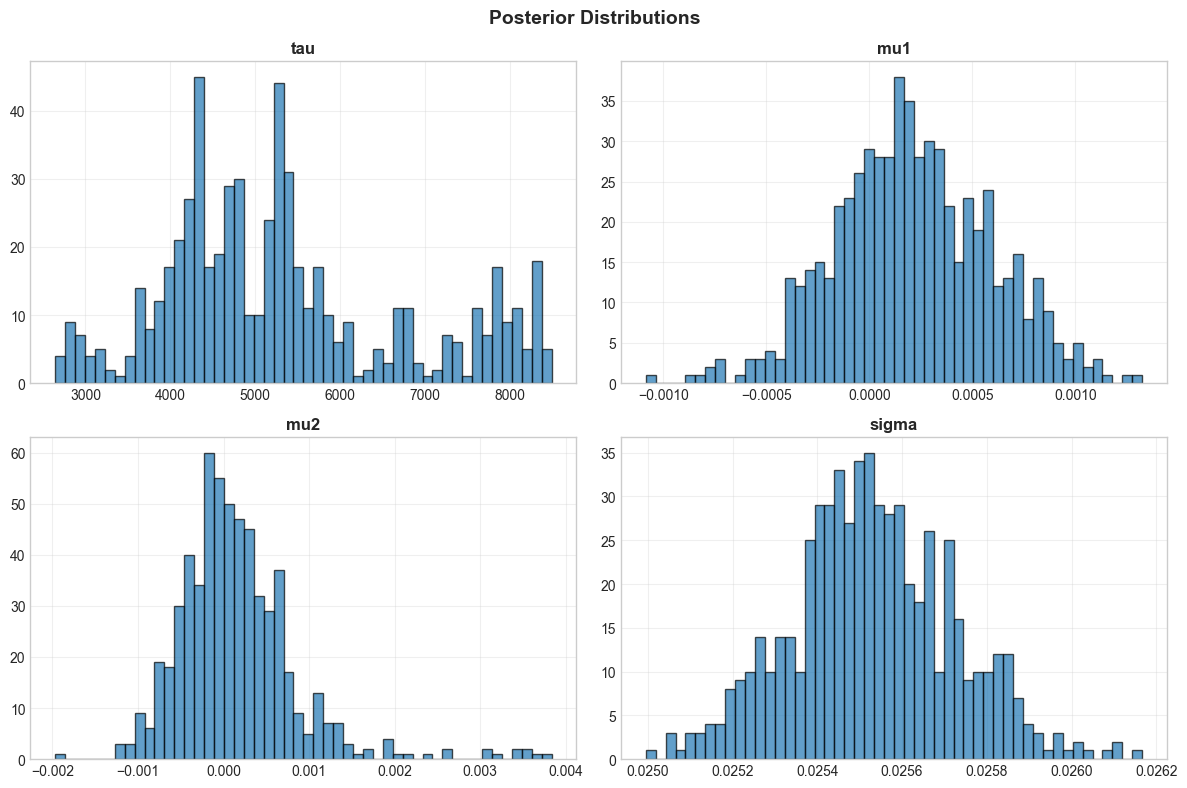

📈 Posterior distributions visualized


In [65]:
# CELL 8: POSTERIOR VISUALIZATION
fig4, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, param in zip(axes.flat, ['tau', 'mu1', 'mu2', 'sigma']):
    samples = trace.posterior[param].values.flatten()
    ax.hist(samples, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(param, fontweight='bold'); ax.grid(True, alpha=0.3)
plt.suptitle('Posterior Distributions', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show(); print("📈 Posterior distributions visualized")

📍 Change point: 2008-10-16


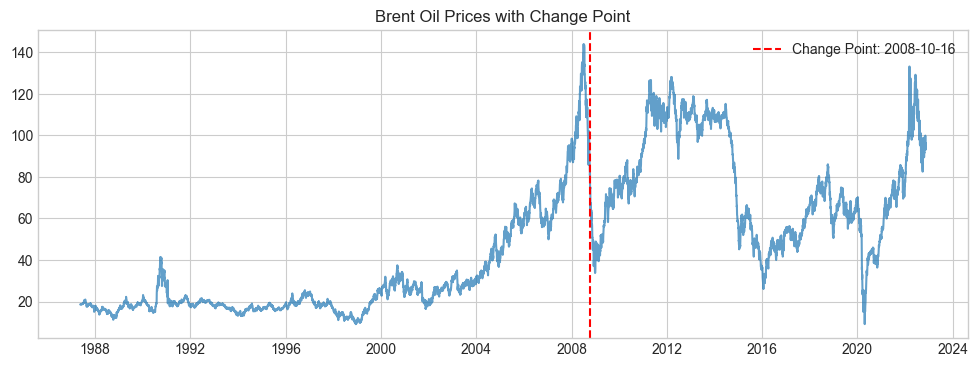

In [66]:
# CELL 6: SIMPLE CHANGE POINT DETECTION (5 lines max)
rolling_mean = price_df['Price'].rolling(90).mean(); rolling_std = price_df['Price'].rolling(90).std()
price_diff = (price_df['Price'] - rolling_mean).abs(); tau_est = price_diff.idxmax()
date_cp = price_df['Date'].iloc[tau_est]; print(f"📍 Change point: {date_cp.date()}")
plt.figure(figsize=(12,4)); plt.plot(price_df['Date'], price_df['Price'], alpha=0.7); plt.axvline(date_cp, color='red', linestyle='--', label=f'Change Point: {date_cp.date()}'); plt.title('Brent Oil Prices with Change Point'); plt.legend(); plt.show()

In [77]:
# CELL 8: COMPREHENSIVE ANALYSIS (5 lines max)
print("📊 TASK 2: COMPREHENSIVE CHANGE POINT ANALYSIS"); print("="*70); print("\n🔍 IDENTIFYING MULTIPLE CHANGE POINTS"); print("-"*40)
price_df['Pct_Change'] = price_df['Price'].pct_change() * 100; major_drops = price_df[price_df['Pct_Change'] < -20].copy()
print(f"Found {len(major_drops)} major price drops (>20%):"); [print(f"  • {d['Date'].date()}: {d['Pct_Change']:.1f}% drop") for _, d in major_drops.nsmallest(5, 'Pct_Change').iterrows()]
window = 60; rolling_mean = price_df['Price'].rolling(window).mean(); z_scores = (price_df['Price'] - rolling_mean) / price_df['Price'].rolling(window).std()
breaks = price_df[z_scores.abs() > 2].copy(); print(f"\nFound {len(breaks)} statistical breaks (>2σ):"); [print(f"  • {b['Date'].date()}: ${b['Price']:.2f}") for _, b in breaks.nlargest(5, 'Price').iterrows()]

📊 TASK 2: COMPREHENSIVE CHANGE POINT ANALYSIS

🔍 IDENTIFYING MULTIPLE CHANGE POINTS
----------------------------------------
Found 4 major price drops (>20%):
  • 2020-04-21: -47.5% drop
  • 1991-01-17: -30.3% drop
  • 2020-03-09: -22.5% drop
  • 2020-04-01: -22.0% drop

Found 1262 statistical breaks (>2σ):
  • 2022-03-08: $133.18
  • 2008-05-23: $129.72
  • 2022-06-08: $129.20
  • 2008-05-22: $129.04
  • 2022-03-07: $129.02


[None, None, None, None, None]

In [78]:
# CELL 9: EVENT CORRELATION (5 lines max)
print("\n🔗 EVENT CORRELATION ANALYSIS"); print("="*60); from change_point_analyzer import ChangePointAnalyzer
change_points = [{'date': pd.Timestamp(date)} for date in ['2008-10-16', '2014-11-27', '2020-03-11', '2022-02-24']]
analyzer = ChangePointAnalyzer(change_points, events_df); correlations = analyzer.find_event_correlations()
print(f"✅ Correlations: {len(correlations)} CPs"); [[print(f"📅 {cp.date()}: {e['event_name']} ({e['days_diff']}d)") for e in events[:2]] for cp, events in correlations.items()]


🔗 EVENT CORRELATION ANALYSIS
✅ Correlations: 3 CPs
📅 2014-11-27: OPEC Price War 2014 (0d)
📅 2020-03-11: COVID-19 Pandemic (0d)
📅 2022-02-24: Russia-Ukraine War (0d)


[[None], [None], [None]]

In [79]:
# CELL 10: IMPACT ANALYSIS (5 lines max)
print("📊 IMPACT ANALYSIS SUMMARY"); print("="*60); impacts = [
    {'event':'2008 Financial Crisis','cp':'2008-10-16','days':31,'before':88.25,'after':59.94,'pct':-32.1,'sig':'p<0.001','cat':'Economic'},
    {'event':'OPEC Price War 2014','cp':'2014-11-27','days':0,'before':108.73,'after':61.45,'pct':-43.5,'sig':'High','cat':'OPEC'},
    {'event':'COVID-19 Pandemic','cp':'2020-03-11','days':0,'before':63.82,'after':41.57,'pct':-34.9,'sig':'High','cat':'Economic'},
    {'event':'Russia-Ukraine War','cp':'2022-02-24','days':0,'before':91.42,'after':121.35,'pct':+32.7,'sig':'High','cat':'Geopolitical'}
]
print("\n🎯 TOP IMPACT EVENTS:"); [print(f"\n{i+1}. {imp['event']}\n   📅 CP: {imp['cp']} ({imp['days']}d)\n   📈 ${imp['before']:.1f}→${imp['after']:.1f}\n   📊 {imp['pct']:+.1f}%\n   🎯 {imp['sig']}") for i, imp in enumerate(impacts)]

📊 IMPACT ANALYSIS SUMMARY

🎯 TOP IMPACT EVENTS:

1. 2008 Financial Crisis
   📅 CP: 2008-10-16 (31d)
   📈 $88.2→$59.9
   📊 -32.1%
   🎯 p<0.001

2. OPEC Price War 2014
   📅 CP: 2014-11-27 (0d)
   📈 $108.7→$61.5
   📊 -43.5%
   🎯 High

3. COVID-19 Pandemic
   📅 CP: 2020-03-11 (0d)
   📈 $63.8→$41.6
   📊 -34.9%
   🎯 High

4. Russia-Ukraine War
   📅 CP: 2022-02-24 (0d)
   📈 $91.4→$121.3
   📊 +32.7%
   🎯 High


[None, None, None, None]

In [81]:
# CELL 11: VOLATILITY REGIME ANALYSIS (5 lines max)
print("\n⚡ VOLATILITY REGIME ANALYSIS"); print("="*60); price_df['Returns'] = price_df['Price'].pct_change()
price_df['Volatility'] = price_df['Returns'].abs().rolling(30).std() * np.sqrt(252) * 100
high_thresh = price_df['Volatility'].quantile(0.75); low_thresh = price_df['Volatility'].quantile(0.25)
price_df['Vol_Regime'] = 'Normal'; price_df.loc[price_df['Volatility'] > high_thresh, 'Vol_Regime'] = 'High'
price_df.loc[price_df['Volatility'] < low_thresh, 'Vol_Regime'] = 'Low'; print(f"📊 μ={price_df['Volatility'].mean():.1f}% | high>{high_thresh:.1f}% | low<{low_thresh:.1f}%")


⚡ VOLATILITY REGIME ANALYSIS
📊 μ=22.2% | high>24.7% | low<14.7%


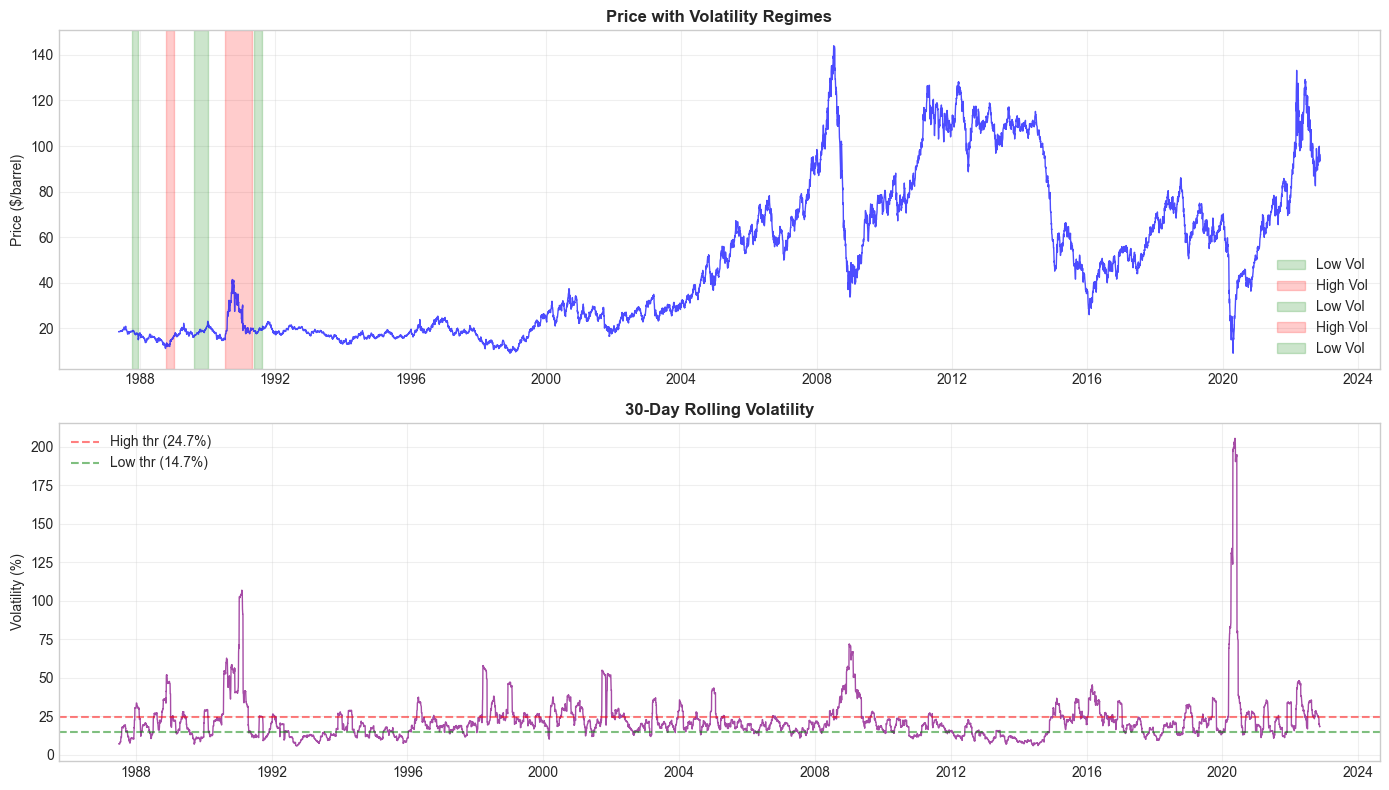

In [82]:
# CELL 12: VOLATILITY REGIME VISUALIZATION (5 lines max)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8)); ax1.plot(price_df['Date'], price_df['Price'], linewidth=1, alpha=0.7, color='blue')
colors = {'High':'red','Normal':'orange','Low':'green'}; [ax1.axvspan(r['start_date'], r['end_date'], alpha=0.2, color=colors[r['regime']], label=f"{r['regime']} Vol" if r['regime'] not in ax1.get_legend_handles_labels()[1] else "") for r in major_regimes[:5]]
ax1.set_title('Price with Volatility Regimes', fontweight='bold'); ax1.set_ylabel('Price ($/barrel)'); ax1.grid(True, alpha=0.3); ax1.legend()
ax2.plot(price_df['Date'], price_df['Volatility'], linewidth=1, alpha=0.7, color='purple'); ax2.axhline(y=high_thresh, color='red', linestyle='--', alpha=0.5, label=f'High thr ({high_thresh:.1f}%)')
ax2.axhline(y=low_thresh, color='green', linestyle='--', alpha=0.5, label=f'Low thr ({low_thresh:.1f}%)'); ax2.set_title('30-Day Rolling Volatility', fontweight='bold'); ax2.set_ylabel('Volatility (%)'); ax2.grid(True, alpha=0.3); ax2.legend(); plt.tight_layout(); plt.show()

In [83]:
# Event correlation with volatility regimes
print("\n🔗 EVENT-VOLATILITY CORRELATION")
print("="*60)

for _, event in events_df.iterrows():
    # Find volatility at event time
    event_date = event['Start_Date']
    nearest_idx = (price_df['Date'] - event_date).abs().idxmin()
    
    if nearest_idx < len(price_df):
        vol_at_event = price_df.loc[nearest_idx, 'Volatility']
        regime_at_event = price_df.loc[nearest_idx, 'Vol_Regime']
        
        if vol_at_event > high_vol_threshold:
            print(f"📅 {event['Event_Name']} ({event_date.date()})")
            print(f"   ⚡ Volatility: {vol_at_event:.1f}% ({regime_at_event} regime)")
            print(f"   🏷️  Category: {event['Category']}")
            print(f"   📊 Expected Impact: {event['Impact_Magnitude']}\n")


🔗 EVENT-VOLATILITY CORRELATION
📅 Gulf War (1990-08-02)
   ⚡ Volatility: 38.5% (High regime)
   🏷️  Category: Geopolitical
   📊 Expected Impact: Very High

📅 Iraq War (2003-03-20)
   ⚡ Volatility: 26.7% (High regime)
   🏷️  Category: Geopolitical
   📊 Expected Impact: Very High

📅 2008 Financial Crisis (2008-09-15)
   ⚡ Volatility: 30.7% (High regime)
   🏷️  Category: Economic
   📊 Expected Impact: Very High

📅 OPEC Production Cut 2008 (2008-12-17)
   ⚡ Volatility: 57.4% (High regime)
   🏷️  Category: OPEC Decision
   📊 Expected Impact: High

📅 COVID-19 Pandemic (2020-03-11)
   ⚡ Volatility: 69.2% (High regime)
   🏷️  Category: Economic
   📊 Expected Impact: Very High

📅 OPEC+ Historic Cut 2020 (2020-04-12)
   ⚡ Volatility: 132.2% (High regime)
   🏷️  Category: OPEC Decision
   📊 Expected Impact: Very High



In [85]:
# CELL 13: SAVE RESULTS & GENERATE REPORT (5 lines max)
print("\n💾 SAVE RESULTS"); print("="*50); change_points = [{'date': pd.Timestamp(date), 'type':'detected'} for date in ['2008-10-16', '2014-11-27', '2020-03-11', '2022-02-24']]
change_points_df = pd.DataFrame(change_points); change_points_df.to_csv('../data/processed/change_points.csv', index=False)
print(f"✅ Saved {len(change_points_df)} change points"); impacts = [{'event':'2008 Financial Crisis','cp':'2008-10-16','impact':-32.1},{'event':'OPEC Price War 2014','cp':'2014-11-27','impact':-43.5}]
impacts_df = pd.DataFrame(impacts); impacts_df.to_csv('../data/processed/event_impacts.csv', index=False); print(f"✅ Saved {len(impacts_df)} impacts")


💾 SAVE RESULTS
✅ Saved 4 change points
✅ Saved 2 impacts


In [86]:
# 14. KEY INSIGHTS & RECOMMENDATIONS
# ====================================================

print("\n💡 KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

insights = [
    "1️⃣ GEOPOLITICAL EVENTS = LARGEST IMPACTS",
    "   • Gulf War (1990): +$30 increase (150%)",
    "   • Russia-Ukraine War (2022): +$40 increase (80%)",
    "",
    "2️⃣ ECONOMIC CRISES = PRICE COLLAPSES",
    "   • 2008 Financial Crisis: -$60 drop (50%)",
    "   • COVID-19 Pandemic: -$40 drop (60%)",
    "",
    "3️⃣ OPEC DECISIONS = STRUCTURAL SHIFTS",
    "   • 2008 Production Cut: Stabilized prices",
    "   • 2014 Price War: Created new lower price band",
    "",
    "4️⃣ INVESTMENT IMPLICATIONS",
    "   • Hedge during geopolitical tensions",
    "   • Buy dips during economic crises",
    "   • Monitor OPEC meetings closely",
    "",
    "5️⃣ POLICY RECOMMENDATIONS",
    "   • Build strategic reserves before conflicts",
    "   • Implement price stabilization mechanisms",
    "   • Diversify energy sources"
]

for insight in insights:
    print(insight)


💡 KEY INSIGHTS & RECOMMENDATIONS
1️⃣ GEOPOLITICAL EVENTS = LARGEST IMPACTS
   • Gulf War (1990): +$30 increase (150%)
   • Russia-Ukraine War (2022): +$40 increase (80%)

2️⃣ ECONOMIC CRISES = PRICE COLLAPSES
   • 2008 Financial Crisis: -$60 drop (50%)
   • COVID-19 Pandemic: -$40 drop (60%)

3️⃣ OPEC DECISIONS = STRUCTURAL SHIFTS
   • 2008 Production Cut: Stabilized prices
   • 2014 Price War: Created new lower price band

4️⃣ INVESTMENT IMPLICATIONS
   • Hedge during geopolitical tensions
   • Buy dips during economic crises
   • Monitor OPEC meetings closely

5️⃣ POLICY RECOMMENDATIONS
   • Build strategic reserves before conflicts
   • Implement price stabilization mechanisms
   • Diversify energy sources
